In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.interpolate
import random

In [2]:
def get_r1p4(MRL_table):
    max_index = np.argmax(MRL_table[:,0])
    clipped_MRL = MRL_table[:max_index-1,:]
        
    diffMRL = np.ediff1d(clipped_MRL[:,0])
    drop_in_m = np.argmax(diffMRL < 0) # index of first drop in mass
    above_m = np.argmax(clipped_MRL[:,0]>clipped_MRL[drop_in_m,0])
    
    keep = np.zeros(clipped_MRL[:,0].shape[0], dtype=bool)
    for i in range(clipped_MRL[:,0].shape[0]):
        keep[i] = i < drop_in_m or i > above_m
        
    fixed_MRL = clipped_MRL[keep,:]
    r_func = scipy.interpolate.CubicSpline(fixed_MRL[:,0], fixed_MRL[:,1])
    r1p4 = r_func(1.4)
    
    return r1p4

def sorted_r1p4(datapath, MRLdir_name):
    numlist = []
    num_mrl = 0

    for file in os.listdir(datapath+MRLdir_name):
            if '.dat' in file:
                numlist.append(int(file[:-4]))
                num_mrl += 1
    
    r1p4 = np.zeros((num_mrl,2))

    for i in range(num_mrl):
        file = datapath+MRLdir_name+'/'+str(i)+'.dat'
        MRL = np.loadtxt(file)

        r1p4[i,0] = get_r1p4(MRL)
        r1p4[i,1] = i

    sorted_index = np.argsort(r1p4[:,0])
    r1p4_sort = r1p4[sorted_index,:]
    
    return r1p4_sort

In [4]:
ext_type = 'cs'
nsamp = 5
newsavename = None

if newsavename == None:
    EOSdir_name = ext_type+str(nsamp)+'EOS'
    MRLdir_name = ext_type+str(nsamp)+'MRL'
    
else:
    EOSdir_name = ext_type+str(nsamp)+'EOS'+newsavename
    MRLdir_name = ext_type+str(nsamp)+'MRL'+newsavename

datapath = "../../eos_data/"

numlist = []
num_eos, num_mrl = 0, 0
for file in os.listdir(datapath+EOSdir_name):
        if '.dat' in file:
            numlist.append(int(file[:-4]))
            num_eos += 1
            
for file in os.listdir(datapath+MRLdir_name):
        if '.dat' in file:
            numlist.append(int(file[:-4]))
            num_mrl += 1

In [5]:
r1p4 = np.zeros((num_eos,2))

for i in range(num_eos):
    file = datapath+MRLdir_name+'/'+str(i)+'.dat'
    MRL = np.loadtxt(file)

    r1p4[i,0] = get_r1p4(MRL)
    r1p4[i,1] = i
    
sorted_index = np.argsort(r1p4[:,0])
r1p4_sort = r1p4[sorted_index,:]

r1p4_sort.shape

(14707, 2)

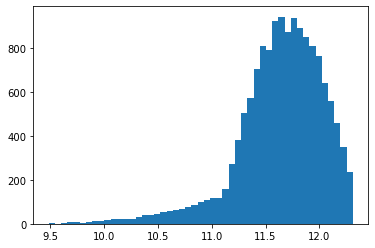

In [6]:
n_EOS = 2000
n_bins = 50
n_per_bin = int(n_EOS/n_bins)

r_min = r1p4_sort[1,0]
r_max = r1p4_sort[-1,0]
delr = (r_max-r_min)/n_bins

bins = np.arange(r_min, r_max, delr)

counts,bin_starts,figure = plt.hist(r1p4_sort[:,0], bins=bins)

In [7]:
in_bin = np.logical_and(r1p4_sort[:,0]<=bins[1],r1p4_sort[:,0]>=bins[0])
print(r1p4_sort[in_bin,0])

[9.48312466 9.49476629 9.51558651]


In [8]:
np.sum(counts)

14614.0

In [40]:
fudge = 30
uniform_r1p4 = np.empty((0,2))
eff_n_per_bin = 51
n_in_bin = np.zeros(n_bins)

j=0
# for i in range(n_bins-1):
#     in_bin = np.logical_and(r1p4_sort[:,0]<=bins[i+1],r1p4_sort[:,0]>bins[i])
#     r1p4_inbin = r1p4_sort[in_bin]
#     count_in_bin = r1p4_inbin.shape[0]
#     if r1p4_inbin.shape[0] < eff_n_per_bin:
#         for ii in range(count_in_bin):
#             uniform_r1p4[j,:] = r1p4_inbin[ii,:]
#             j+=1

#     elif count_in_bin >= eff_n_per_bin:
#         for ii in range(eff_n_per_bin):
#             uniform_r1p4[j,:] = r1p4_inbin[ii,:]
#             j+=1
#     n_in_bin[i] = ii

for i in range(n_bins-1):
    
    in_bin = np.logical_and(r1p4_sort[:,0]<=bins[i+1],r1p4_sort[:,0]>bins[i])
    sample_set = r1p4_sort[in_bin]
    count_in_bin = r1p4_inbin.shape[0]
    
    if sample_set.shape[0] > eff_n_per_bin:
        size = int(sample_set.shape[0])
        zero2size = np.arange(0,size,1)
        rints = np.random.choice(zero2size, size=eff_n_per_bin, replace=False)
        in_sample = np.zeros(size, dtype=bool)
        for j in range(size):
            in_sample[j] = zero2size[j] in rints
        sample = sample_set[in_sample,:]
        
        uniform_r1p4 = np.append(uniform_r1p4, sample, axis=0)
        
    else:
        uniform_r1p4 = np.append(uniform_r1p4, sample_set, axis=0)

In [41]:
# remove all the zeros from the uniform array

num_entry = 0
for r in uniform_r1p4[:,0]:
    if r!=0:
        num_entry +=1
        
fixed_uniform = np.zeros((num_entry,2))

i = 0
for r in uniform_r1p4[:,0]:
    if r!=0:
        fixed_uniform[i,:] = uniform_r1p4[i,:]
        i+=1

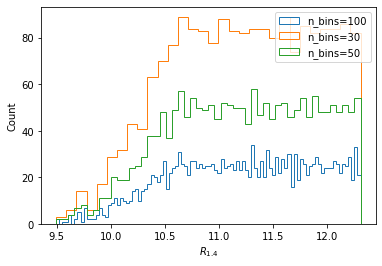

In [42]:
plt.hist(fixed_uniform[:,0], histtype='step', bins=100, label="n_bins=100")
plt.hist(fixed_uniform[:,0], histtype='step', bins=30, label="n_bins=30")
plt.hist(fixed_uniform[:,0], histtype='step', bins=50, label="n_bins=50")
plt.xlabel(r"$R_{1.4}$")
plt.ylabel("Count")
plt.legend()

In [23]:
np.sum(counts)

2012.0

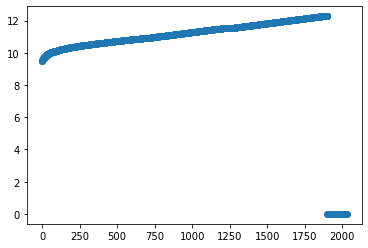

In [14]:
plt.plot(range(0,n_EOS+fudge),uniform_r1p4[:,0], 'o')


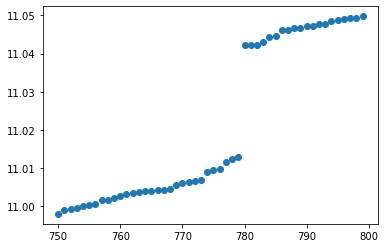

In [15]:
n_min, n_max = 750, 800
plt.plot(range(n_min,n_max),uniform_r1p4[n_min:n_max,0], 'o')

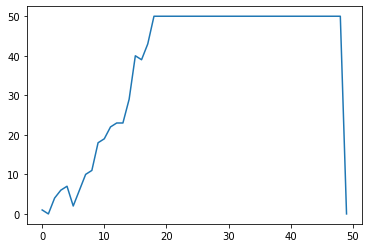

In [24]:
plt.plot(range(0,n_bins),n_in_bin)

## Save EOS

In [25]:
j=0
for i in uniform_r1p4[:,1]:
    old_file = datapath+MRLdir_name+'/'+str(int(i))+'.dat'
    MRL = np.loadtxt(old_file)

    if not(MRLdir_name+"_uniform" in os.listdir(datapath)):
        os.makedirs(datapath+MRLdir_name+"_uniform")

    new_file = datapath+MRLdir_name+'_uniform/'+str(j)+'.dat'
    np.savetxt(new_file, MRL)
    j+=1

In [26]:
j=0
for i in uniform_r1p4[:,1]:
    old_file = datapath+EOSdir_name+'/'+str(int(i))+'.dat'
    EOS = np.loadtxt(old_file)
    with open(old_file, 'r') as f:
        header = f.readline()

    if not(EOSdir_name+"_uniform" in os.listdir(datapath)):
        os.makedirs(datapath+EOSdir_name+"_uniform")

    new_file = datapath+EOSdir_name+'_uniform/'+str(j)+'.dat'
    np.savetxt(new_file, EOS, header=header)
    j+=1

## True Uniform Distributions
(drawing from all MRL sets)

In [45]:
set_list = [["cs",3,None],["cs",5,None],["poly",5,None]]
r1p4_list = []

datapath = "../../eos_data/"
    
indices = np.zeros(len(set_list)+1)

i=0
for item in set_list:
    ext_type, nsamp, newsavename = item[0],item[1], item[2]
    if newsavename == None:
        MRLdir_name = ext_type+str(nsamp)+'MRL'
    else:
        MRLdir_name = ext_type+str(nsamp)+'MRL'+newsavename

    r1p4_sort = sorted_r1p4(datapath, MRLdir_name)
    r1p4_list.append([r1p4_sort, MRLdir_name])
    
    indices[i+1] = len(r1p4_sort[:,0]) + indices[i]
    print(indices[i+1])
    i+=1


9753.0
24460.0
27348.0


In [46]:
big_r1p4 = np.zeros((int(indices[-1]),2))

ii=0
for item in r1p4_list:
    big_r1p4[int(indices[ii]):int(indices[ii+1]),0] = item[0][:,0]
    
    if item[1] == "cs3MRL":
        big_r1p4[int(indices[ii]):int(indices[ii+1]),1] = item[0][:,1] -20000
    elif item[1] == "poly5MRL":
        big_r1p4[int(indices[ii]):int(indices[ii+1]),1] = item[0][:,1] +20000
    else:
        big_r1p4[int(indices[ii]):int(indices[ii+1]),1] = item[0][:,1]
    
    ii+=1
    
sorted_index = np.argsort(big_r1p4[:,0])
big_r1p4_sort = big_r1p4[sorted_index,:]

In [47]:
uniform_big_r1p4 = np.empty((0,2))
eff_n_per_bin = 50

j=0
# for i in range(n_bins-1):
#     in_bin = np.logical_and(big_r1p4_sort[:,0]<=bins[i+1],big_r1p4_sort[:,0]>=bins[i])
#     r1p4_inbin = big_r1p4_sort[in_bin]
#     count_in_bin = r1p4_inbin.shape[0]
#     if r1p4_inbin.shape[0] < eff_n_per_bin:
#         for ii in range(count_in_bin):
#             uniform_big_r1p4[j,:] = r1p4_inbin[ii,:]
#             j+=1

#     elif count_in_bin >= eff_n_per_bin:
#         for ii in range(eff_n_per_bin):
#             uniform_big_r1p4[j,:] = r1p4_inbin[ii,:]
#             j+=1
            
for i in range(n_bins-1):
    
    in_bin = np.logical_and(big_r1p4_sort[:,0]<=bins[i+1],big_r1p4_sort[:,0]>bins[i])
    sample_set = big_r1p4_sort[in_bin]
    count_in_bin = sample_set.shape[0]
    
    if sample_set.shape[0] > eff_n_per_bin:
        size = int(sample_set.shape[0])
        zero2size = np.arange(0,size,1)
        rints = np.random.choice(zero2size, size=eff_n_per_bin, replace=False)
        in_sample = np.zeros(size, dtype=bool)
        for j in range(size):
            in_sample[j] = zero2size[j] in rints
        sample = sample_set[in_sample,:]
        
        uniform_big_r1p4 = np.append(uniform_big_r1p4, sample, axis=0)
        
    else:
        uniform_big_r1p4 = np.append(uniform_big_r1p4, sample_set, axis=0)

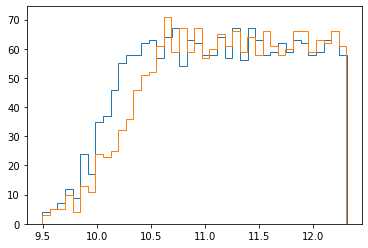

In [52]:
big_counts,_,_ = plt.hist(uniform_big_r1p4[:,0], bins=40, histtype='step')
counts,_,_ = plt.hist(uniform_r1p4[:,0], bins=40, histtype='step')

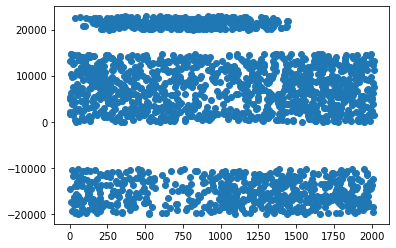

In [49]:
# checking to be sure my differentiation worked
plt.plot(range(0,uniform_big_r1p4[:,1].shape[0]),uniform_big_r1p4[:,1], 'o')

In [89]:
if not("MRL_uniform" in os.listdir(datapath)):
    os.makedirs(datapath+"MRL_uniform")

j=0
for i in uniform_big_r1p4[:,1]:
    if i > 19999:
        MRLdir_name = "poly5MRL/"
        old_file = datapath+MRLdir_name+str(int(i-20000))+'.dat'
        MRL = np.loadtxt(old_file)
    elif i < -500:
        MRLdir_name = "cs3MRL/"
        old_file = datapath+MRLdir_name+str(int(i+20000))+'.dat'
        MRL = np.loadtxt(old_file)
    else:
        MRLdir_name = "cs5MRL/"
        old_file = datapath+MRLdir_name+str(int(i))+'.dat'
        MRL = np.loadtxt(old_file)

    new_file = datapath+'MRL_uniform/'+str(j)+'.dat'
    np.savetxt(new_file, MRL)
    j+=1

In [90]:
j=0
for i in uniform_r1p4[:,1]:
    if i > 19999:
        EOSdir_name = "poly5EOS/"
        old_file = datapath+EOSdir_name+str(int(i-20000))+'.dat'
    elif i < -500:
        EOSdir_name = "cs3EOS/"
        old_file = datapath+EOSdir_name+str(int(i+20000))+'.dat'
    else:
        EOSdir_name = "cs5EOS/"
        old_file = datapath+EOSdir_name+str(int(i))+'.dat'

    EOS = np.loadtxt(old_file)
    with open(old_file, 'r') as f:
        header = f.readline()

    if not("EOS_uniform" in os.listdir(datapath)):
        os.makedirs(datapath+"EOS_uniform")

    new_file = datapath+'EOS_uniform/'+str(j)+'.dat'
    np.savetxt(new_file, EOS, header=header)
    j+=1